# Calculating fisher score in the training of the CNN

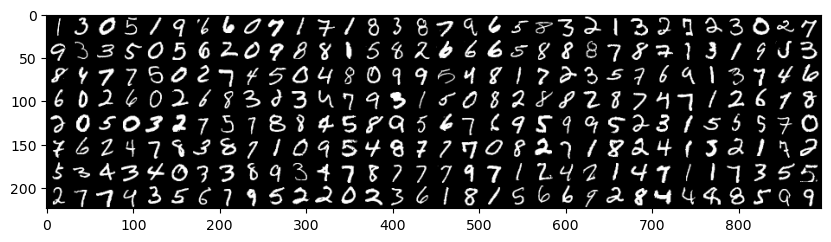

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

datadir = "./data"
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(datadir, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_set = datasets.MNIST(datadir, train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

tmp_loader = DataLoader(val_set, batch_size=1000, shuffle=True)
X_display, y_display = val_loader.__iter__().next()

X, y = train_loader.__iter__().next()
out = X.detach().numpy()
out = out.reshape(8, int(batch_size / 8),28,28)
out = out.transpose(0,2,1,3)
out = out.reshape(8*28,int(batch_size / 8)*28)
out = (out*(batch_size - 1)).astype(np.uint8)

plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(out, "gray")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,1)
        self.conv2 = nn.Conv2d(16,16,3,1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.dim_feature = 128
        self.fc1 = nn.Linear(12*12*16, self.dim_feature)
        self.fc2 = nn.Linear(self.dim_feature, 10)
        
        self._last_feature = None

    def forward(self,x):
        x = self.conv1(x)
        x = f.relu(x)
        x = self.conv2(x)
        x = f.relu(x)
        x = self.pool(x)
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = torch.tanh(x)
                
        self._last_feature = x.detach()
        
        x = self.fc2(x)

        return f.log_softmax(x, dim=1)
    
    @property
    def last_feature(self):
        return self._last_feature.detach()
    
net = CNNmodel()
print(net)

CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
#エポック数，バッジサイズ
epoch = 100

#学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": [],
    "fisher_score": [],
    "tr_b": [],
    "tr_w": [],
}

data_loader = {"train":train_loader, "validation":val_loader}

#GPUが使えるときは使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#ネットワーク構造の構築
net = CNNmodel().to(device)
print(net)

#最適化方法の設定
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

cpu
CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
# Fisher descriminant ratio

def fisher_descriminant_score():
    net.eval()
    
    n_class = len(set(val_set.targets.numpy()))
    n_for_each_class = {i: 0 for i in range(n_class)}

    mean_global = np.zeros(net.dim_feature)
    mean_c = np.zeros((n_class, net.dim_feature))
    
    s_c = np.zeros((n_class, net.dim_feature, net.dim_feature))
    s_W = np.zeros((net.dim_feature, net.dim_feature))
    s_B = np.zeros((net.dim_feature, net.dim_feature))

    with torch.no_grad():
        # Calculate global mean
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            #順伝搬の計算
            net(data)

            x = net.last_feature.numpy()

            for i in range(len(data)):
                mean_global += x[i]

                c = int(target.numpy()[i])
                x_c = x[i]

                mean_c[c] += x_c
                n_for_each_class[c] += 1        
                
    # get global mean
    n_all = np.sum(list(n_for_each_class.values()))
    mean_global /= n_all
        
    # get class mean
    for c in range(n_class):
        mean_c[c] /= n_for_each_class[c]

    # within-class scatter
    with torch.no_grad():
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            net(data)

            for i in range(len(data)):
                c = int(target[i].numpy())
                x_hat_c = net.last_feature[i].numpy()
                mu = np.atleast_2d(x_hat_c - mean_c[c])
                s = np.dot(mu, mu.transpose())
                s_c[c] += s

    s_W = np.sum(s_c, axis=0)

    # between-class scatter
    for c in range(n_class):
        mu = np.atleast_2d(mean_c[c] - mean_global)
        s = n_for_each_class[c] * np.dot(mu, mu.transpose())
        s_B += s

    # Fisher descriminant ratio-based score
    fisher_disc_ratio = np.dot(np.linalg.pinv(s_W), s_B)
    score = np.trace(fisher_disc_ratio)
        
    return score, np.trace(s_B), np.trace(s_W)

print("example (score, between_class_cov_tr, within_class_cov_tr): ", fisher_descriminant_score())

example (score, between_class_cov_tr, within_class_cov_tr):  (0.33448935511076877, 49149.00856463913, 146937.43706242339)



Train start
Training: 1 epoch. 100 iteration. Loss:0.20525005459785461
Training loss (ave.): 0.24544354658177558

Validation start:
Validation loss: 0.23859148027896881, Accuracy: 0.9325

Fisher discrinimant measure start:
Fisher desctiminant score: 1.5814713442528043
within-class cov: 42624138.22797726, between-class cov: 67408853.18101647


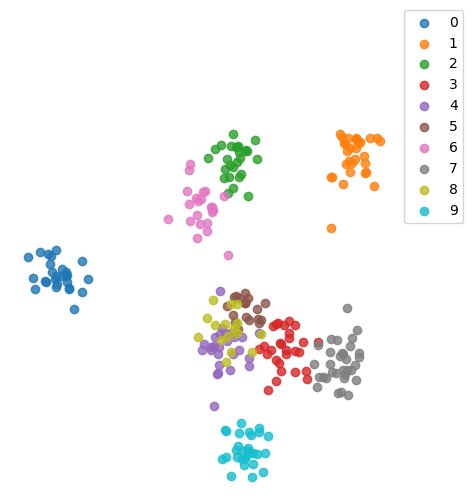

---

Train start
Training: 2 epoch. 100 iteration. Loss:0.2001277506351471
Training loss (ave.): 0.08493448083705091

Validation start:
Validation loss: 0.13745163078904152, Accuracy: 0.9592

Fisher discrinimant measure start:
Fisher desctiminant score: 1.7873390023908866
within-class cov: 39267427.57935592, between-class cov: 70184204.8361421


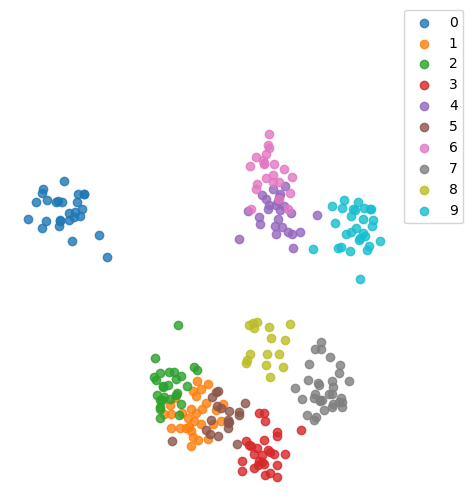

---

Train start
Training: 3 epoch. 100 iteration. Loss:0.09999460726976395
Training loss (ave.): 0.050983075512216446

Validation start:
Validation loss: 0.09318027932941914, Accuracy: 0.9736

Fisher discrinimant measure start:
Fisher desctiminant score: 1.943319592798793
within-class cov: 35782885.38858114, between-class cov: 69537582.26250336


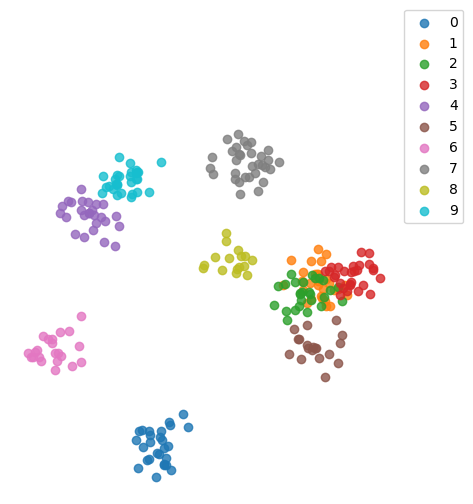

---

Train start
Training: 4 epoch. 100 iteration. Loss:0.08767372369766235
Training loss (ave.): 0.035299424097893085

Validation start:
Validation loss: 0.07531197044849396, Accuracy: 0.9775

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0510263186204507
within-class cov: 35451543.777422674, between-class cov: 72712049.32321903


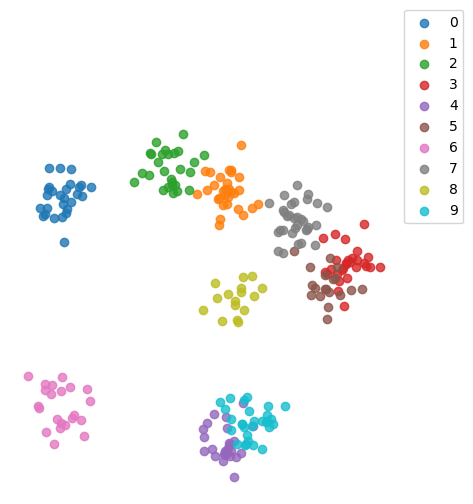

---

Train start
Training: 5 epoch. 100 iteration. Loss:0.049156561493873596
Training loss (ave.): 0.029042337644607463

Validation start:
Validation loss: 0.06426688532978296, Accuracy: 0.9808

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9343141443832224
within-class cov: 36689375.2347817, between-class cov: 70968777.46522179


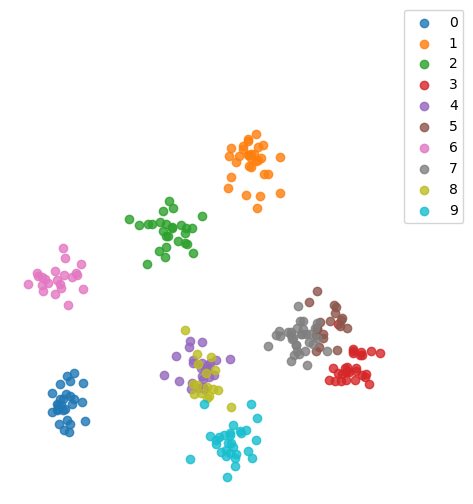

---

Train start
Training: 6 epoch. 100 iteration. Loss:0.0983235314488411
Training loss (ave.): 0.02380508746396988

Validation start:
Validation loss: 0.052544072687625884, Accuracy: 0.9833

Fisher discrinimant measure start:
Fisher desctiminant score: 1.932458657019084
within-class cov: 38743856.3563813, between-class cov: 74870900.622193


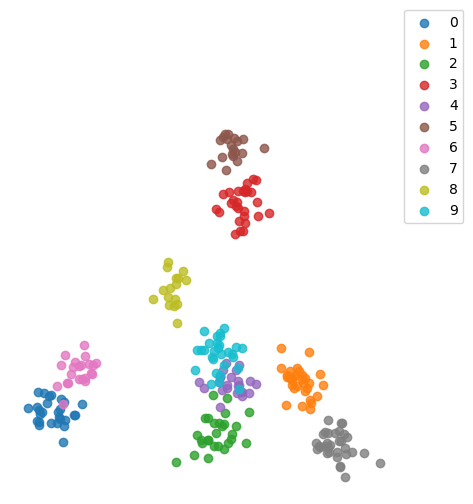

---

Train start
Training: 7 epoch. 100 iteration. Loss:0.03324450924992561
Training loss (ave.): 0.020132347140857515

Validation start:
Validation loss: 0.047762985062599184, Accuracy: 0.9851

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8891709583488137
within-class cov: 39617098.98902249, between-class cov: 74843472.86409141


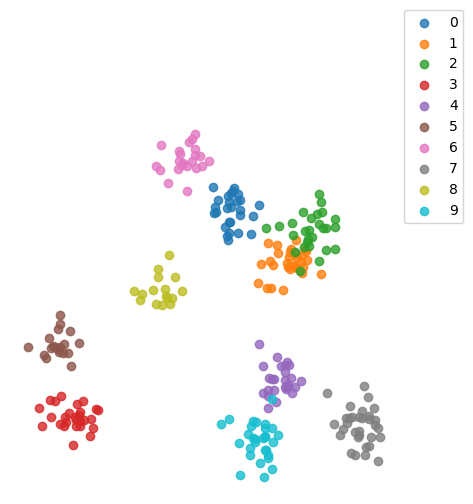

---

Train start
Training: 8 epoch. 100 iteration. Loss:0.018005022779107094
Training loss (ave.): 0.0176938768753663

Validation start:
Validation loss: 0.044853433609008786, Accuracy: 0.9855

Fisher discrinimant measure start:
Fisher desctiminant score: 1.76654052243333
within-class cov: 41892559.59868313, between-class cov: 74004904.11952698


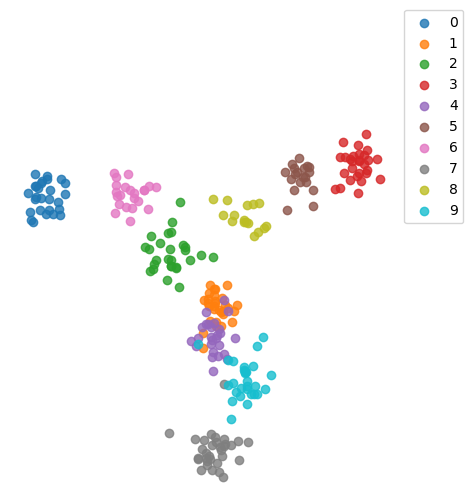

---

Train start
Training: 9 epoch. 100 iteration. Loss:0.028041325509548187
Training loss (ave.): 0.01527405599964426

Validation start:
Validation loss: 0.04497106216698885, Accuracy: 0.9839

Fisher discrinimant measure start:
Fisher desctiminant score: 1.760085240405679
within-class cov: 43121808.302594975, between-class cov: 75898058.33300029


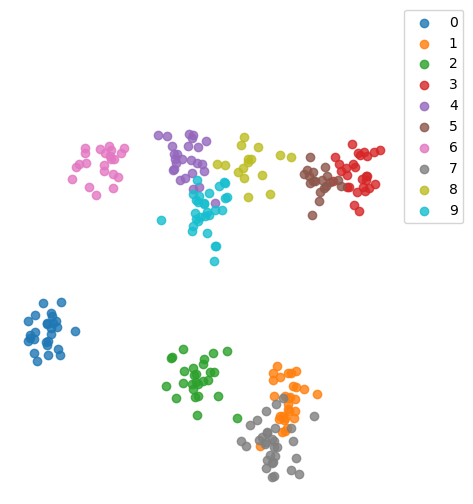

---

Train start
Training: 10 epoch. 100 iteration. Loss:0.020536957308650017
Training loss (ave.): 0.013378870221687125

Validation start:
Validation loss: 0.04267983839213848, Accuracy: 0.9867

Fisher discrinimant measure start:
Fisher desctiminant score: 1.7135614544459647
within-class cov: 44281180.72942449, between-class cov: 75878524.4552972


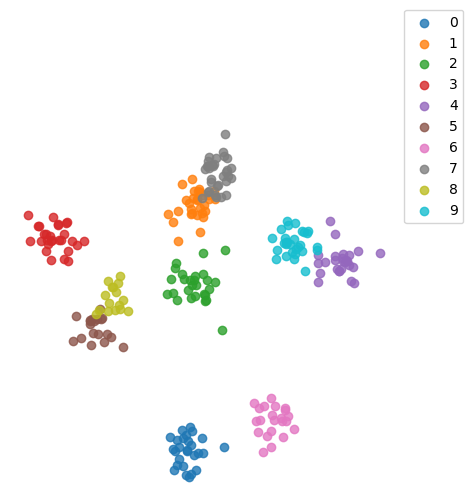

---

Train start
Training: 11 epoch. 100 iteration. Loss:0.02128203772008419
Training loss (ave.): 0.011381432731100854

Validation start:
Validation loss: 0.036081457401812074, Accuracy: 0.9881

Fisher discrinimant measure start:
Fisher desctiminant score: 1.7014270745172566
within-class cov: 44474764.567178205, between-class cov: 75670568.56737791


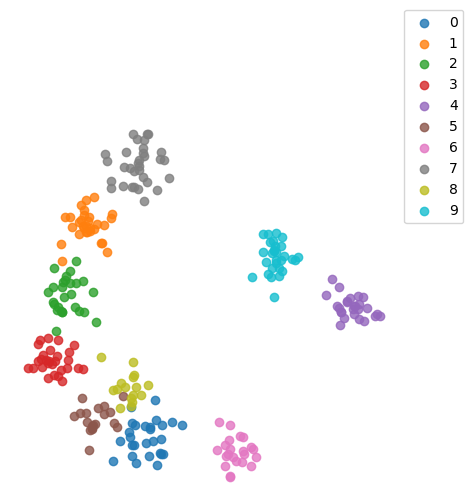

---

Train start
Training: 12 epoch. 100 iteration. Loss:0.011659258045256138
Training loss (ave.): 0.009840637086791561

Validation start:
Validation loss: 0.03634936246871948, Accuracy: 0.9869

Fisher discrinimant measure start:
Fisher desctiminant score: 1.673190890769718
within-class cov: 45523481.29575113, between-class cov: 76169474.22017658


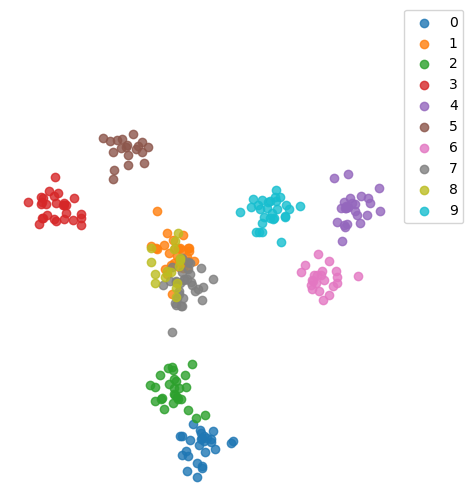

---

Train start
Training: 13 epoch. 100 iteration. Loss:0.02113034948706627
Training loss (ave.): 0.00980269577790131

Validation start:
Validation loss: 0.03711996502950787, Accuracy: 0.9871

Fisher discrinimant measure start:
Fisher desctiminant score: 1.5953856401767152
within-class cov: 46870936.53088152, between-class cov: 74777219.08300246


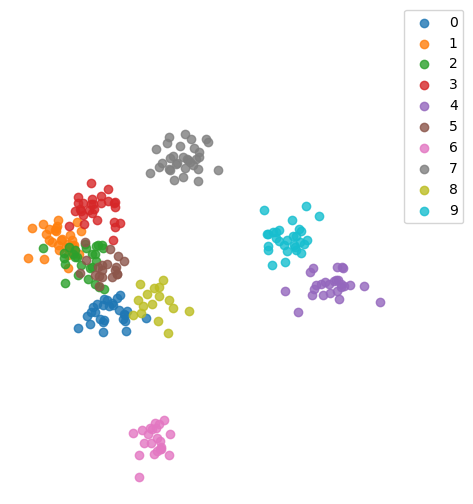

---

Train start
Training: 14 epoch. 100 iteration. Loss:0.018071115016937256
Training loss (ave.): 0.007418318837881088

Validation start:
Validation loss: 0.03446727847009897, Accuracy: 0.9881

Fisher discrinimant measure start:
Fisher desctiminant score: 1.6140210278074671
within-class cov: 46448547.22721974, between-class cov: 74968931.93584071


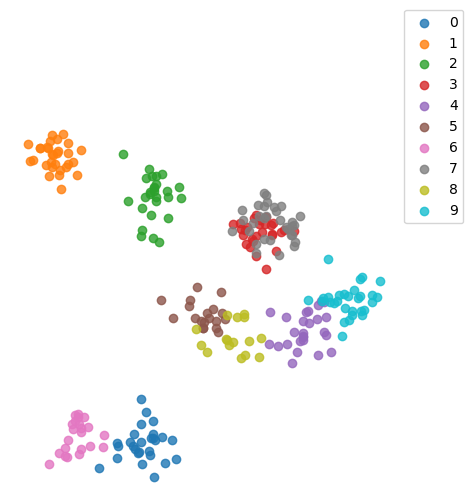

---

Train start
Training: 15 epoch. 100 iteration. Loss:0.05814172700047493
Training loss (ave.): 0.007279492126024784

Validation start:
Validation loss: 0.03459697645306587, Accuracy: 0.9878

Fisher discrinimant measure start:
Fisher desctiminant score: 1.540890982691367
within-class cov: 48863984.37101761, between-class cov: 75294072.89567302


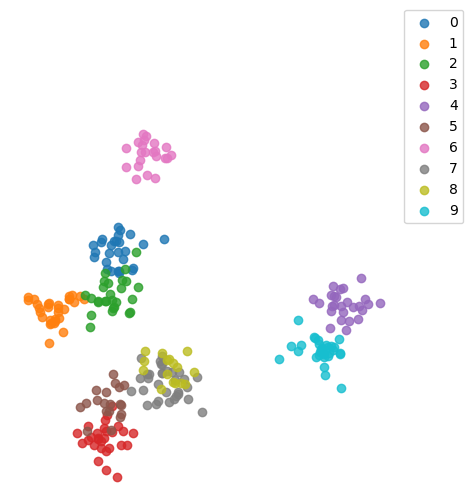

---

Train start
Training: 16 epoch. 100 iteration. Loss:0.039928752928972244
Training loss (ave.): 0.00739396106887688

Validation start:
Validation loss: 0.033611606907844545, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.5272939921836366
within-class cov: 49264026.66723653, between-class cov: 75240651.9596447


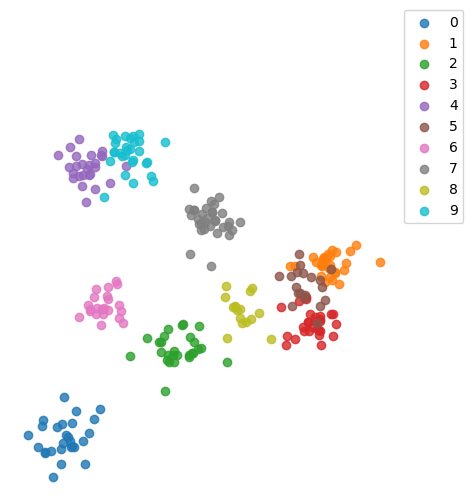

---

Train start
Training: 17 epoch. 100 iteration. Loss:0.012734276242554188
Training loss (ave.): 0.006015066245689671

Validation start:
Validation loss: 0.034141403323411944, Accuracy: 0.9877

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4876133081649239
within-class cov: 50794863.47345289, between-class cov: 75563114.88952877


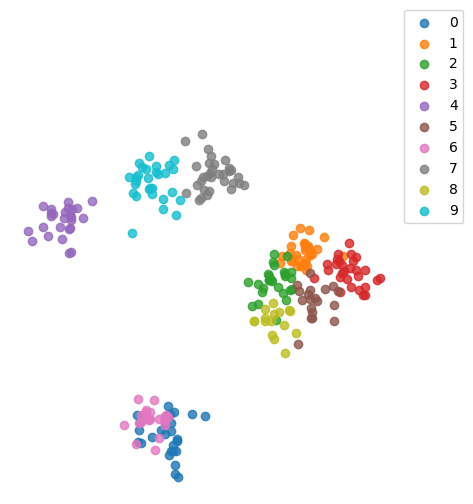

---

Train start
Training: 18 epoch. 100 iteration. Loss:0.019967596977949142
Training loss (ave.): 0.0059330481629660155

Validation start:
Validation loss: 0.03287341481670737, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.5147360264436984
within-class cov: 50367154.695570864, between-class cov: 76292943.76684402


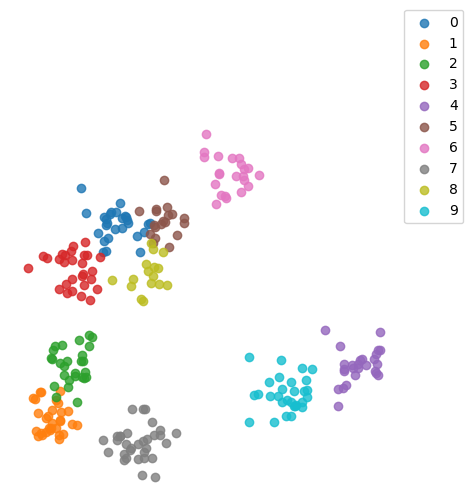

---

Train start
Training: 19 epoch. 100 iteration. Loss:0.01146035548299551
Training loss (ave.): 0.004771898709673514

Validation start:
Validation loss: 0.03744506379365921, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4613944220224748
within-class cov: 50895168.474132694, between-class cov: 74377915.31599176


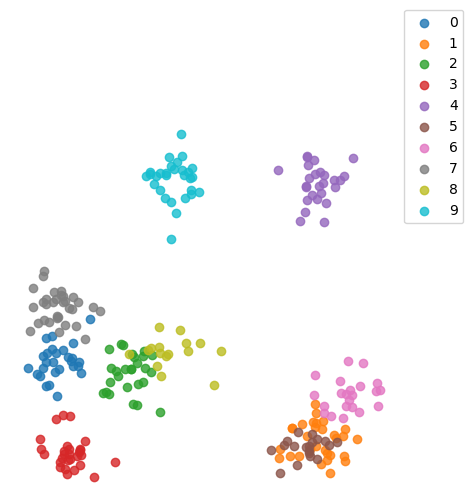

---

Train start
Training: 20 epoch. 100 iteration. Loss:0.004524687305092812
Training loss (ave.): 0.004367638811310555

Validation start:
Validation loss: 0.03484259663447738, Accuracy: 0.9877

Fisher discrinimant measure start:
Fisher desctiminant score: 1.504769395482461
within-class cov: 50829321.179681905, between-class cov: 76486406.9043337


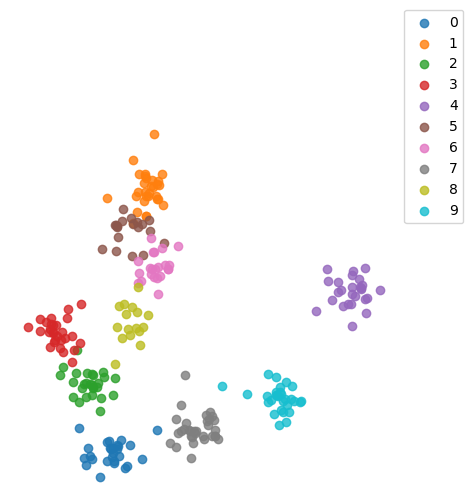

---

Train start
Training: 21 epoch. 100 iteration. Loss:0.0075391316786408424
Training loss (ave.): 0.003897670943765564

Validation start:
Validation loss: 0.03354715964552015, Accuracy: 0.9886

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4680236135528348
within-class cov: 51932898.69901948, between-class cov: 76238721.61040781


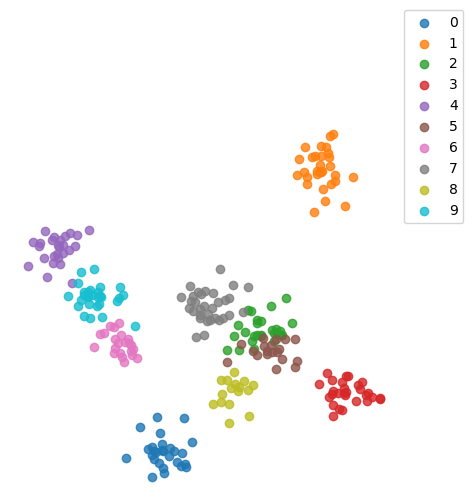

---

Train start
Training: 22 epoch. 100 iteration. Loss:0.006875879131257534
Training loss (ave.): 0.003523988277215431

Validation start:
Validation loss: 0.030716522939503194, Accuracy: 0.9888

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4391276257596342
within-class cov: 52222677.555104025, between-class cov: 75155097.96068786


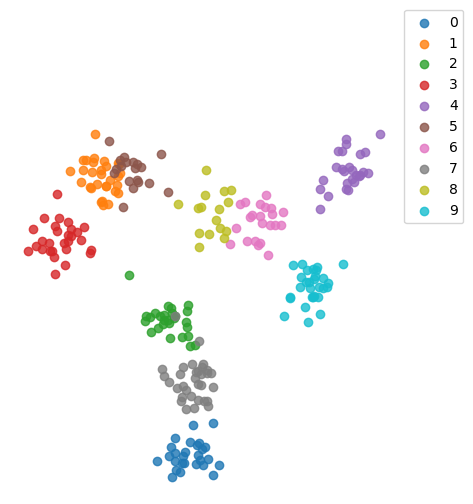

---

Train start
Training: 23 epoch. 100 iteration. Loss:0.004375706892460585
Training loss (ave.): 0.0029627781559495216

Validation start:
Validation loss: 0.03273060830831528, Accuracy: 0.9894

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4582257912458447
within-class cov: 52571519.17470911, between-class cov: 76661145.14553627


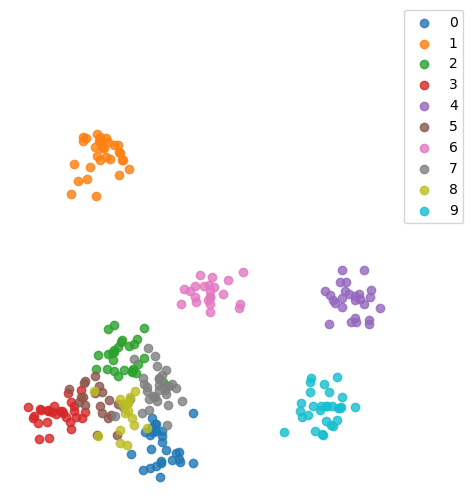

---

Train start
Training: 24 epoch. 100 iteration. Loss:0.008643156848847866
Training loss (ave.): 0.0026458976567385996

Validation start:
Validation loss: 0.03239495104067028, Accuracy: 0.989

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4658325479438266
within-class cov: 52407862.131025515, between-class cov: 76821150.07981002


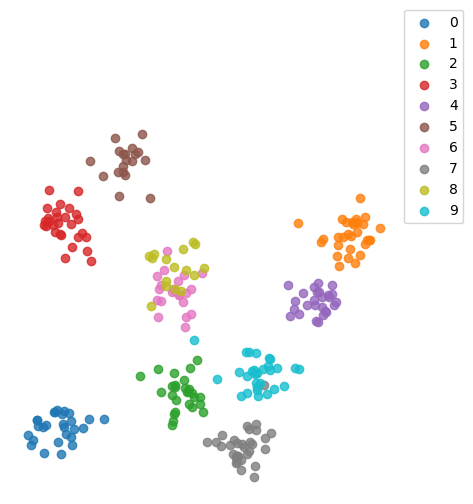

---

Train start
Training: 25 epoch. 100 iteration. Loss:0.0066754985600709915
Training loss (ave.): 0.0023067298429483114

Validation start:
Validation loss: 0.032092406139313245, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.46783160154509
within-class cov: 52652683.41398815, between-class cov: 77285272.62120058


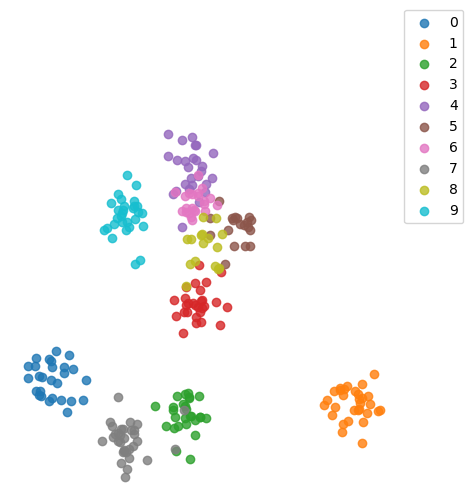

---

Train start
Training: 26 epoch. 100 iteration. Loss:0.017364999279379845
Training loss (ave.): 0.0019479114829780574

Validation start:
Validation loss: 0.03149299547076225, Accuracy: 0.9889

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4505016570414282
within-class cov: 53180686.757650346, between-class cov: 77138674.26457277


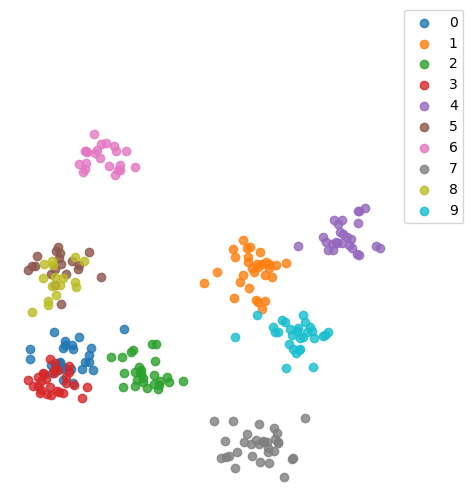

---

Train start
Training: 27 epoch. 100 iteration. Loss:0.0027730229776352644
Training loss (ave.): 0.0017447670282637502

Validation start:
Validation loss: 0.03377796099120751, Accuracy: 0.9886

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4356480736262538
within-class cov: 53741668.06894164, between-class cov: 77154122.23663744


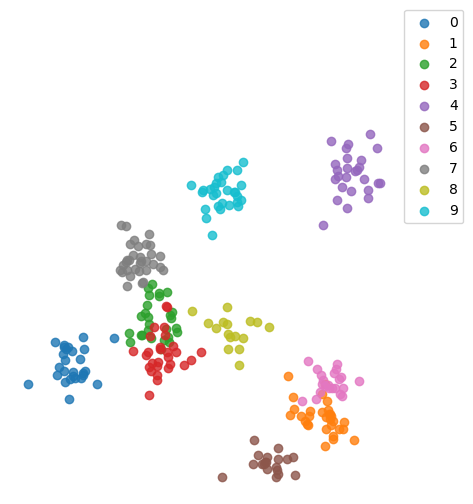

---

Train start
Training: 28 epoch. 100 iteration. Loss:0.0009426518226973712
Training loss (ave.): 0.0018889149499839131

Validation start:
Validation loss: 0.03144112902879715, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4389770436482439
within-class cov: 53344592.45787696, between-class cov: 76761643.94965626


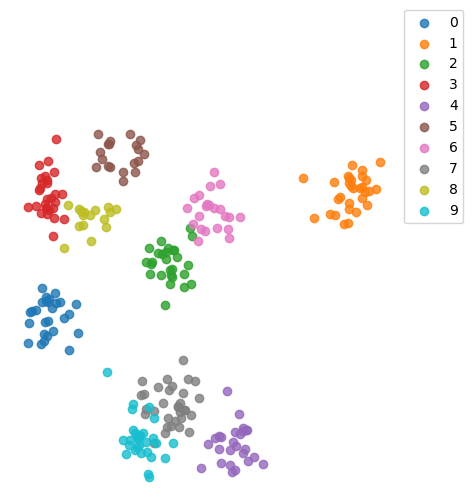

---

Train start
Training: 29 epoch. 100 iteration. Loss:0.005916282068938017
Training loss (ave.): 0.0013040863183089236

Validation start:
Validation loss: 0.030452305063605307, Accuracy: 0.9898

Fisher discrinimant measure start:
Fisher desctiminant score: 1.454739707726648
within-class cov: 53877943.933374256, between-class cov: 78378384.41054973


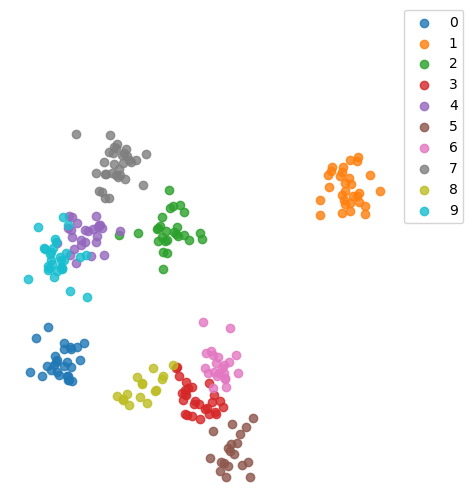

---

Train start
Training: 30 epoch. 100 iteration. Loss:0.005992962513118982
Training loss (ave.): 0.001549140324300908

Validation start:
Validation loss: 0.031528426031395794, Accuracy: 0.9881

Fisher discrinimant measure start:
Fisher desctiminant score: 1.452000334769345
within-class cov: 53778027.18308341, between-class cov: 78085713.47307208


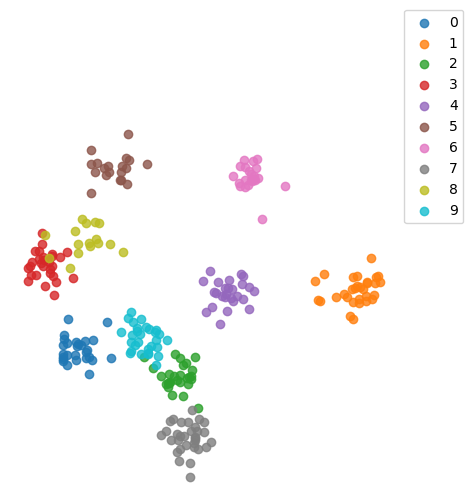

---

Train start
Training: 31 epoch. 100 iteration. Loss:0.0013342483434826136
Training loss (ave.): 0.0012363019050098956

Validation start:
Validation loss: 0.03192845491170883, Accuracy: 0.9902

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4381004031037894
within-class cov: 53627067.20191193, between-class cov: 77121106.96034375


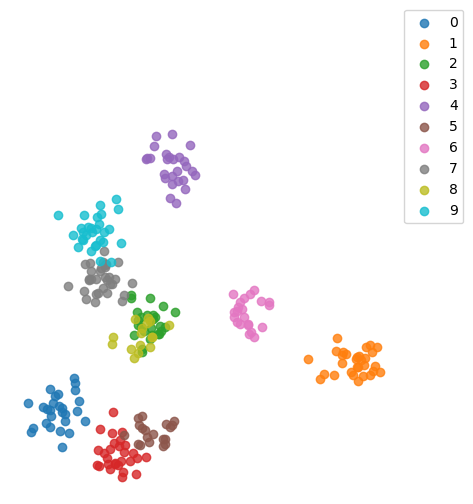

---

Train start
Training: 32 epoch. 100 iteration. Loss:0.002164626494050026
Training loss (ave.): 0.0012503988342359661

Validation start:
Validation loss: 0.030483633011579515, Accuracy: 0.9903

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4208098409089016
within-class cov: 54297262.335321195, between-class cov: 77146084.66043654


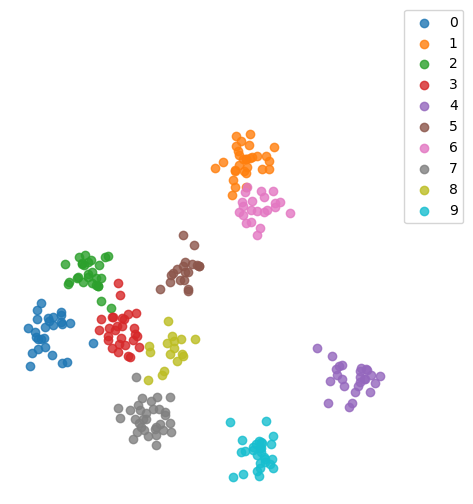

---

Train start
Training: 33 epoch. 100 iteration. Loss:0.0018822132842615247
Training loss (ave.): 0.000941293029748696

Validation start:
Validation loss: 0.03253427003789693, Accuracy: 0.9891

Fisher discrinimant measure start:
Fisher desctiminant score: 1.422431047874909
within-class cov: 54584881.22278453, between-class cov: 77643229.7958529


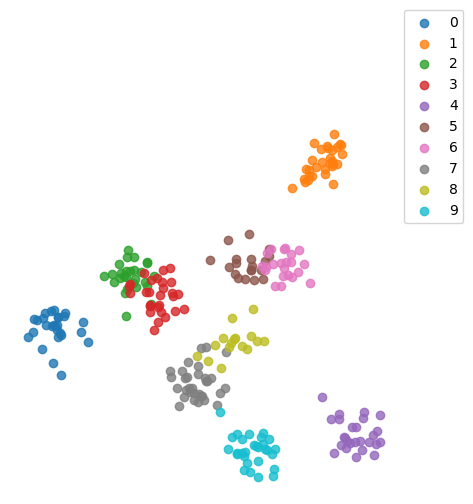

---

Train start
Training: 34 epoch. 100 iteration. Loss:0.002669277135282755
Training loss (ave.): 0.001026119933181264

Validation start:
Validation loss: 0.03138766009202227, Accuracy: 0.9893

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4431331936131924
within-class cov: 54180288.04676941, between-class cov: 78189372.11981685


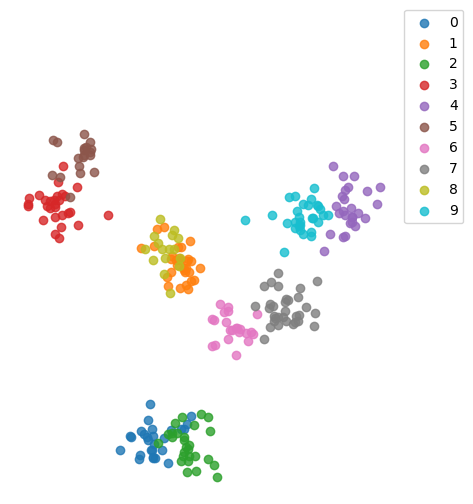

---

Train start
Training: 35 epoch. 100 iteration. Loss:0.0005316578317433596
Training loss (ave.): 0.0008969663414470059

Validation start:
Validation loss: 0.033913721744716165, Accuracy: 0.9884

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4356443835502364
within-class cov: 54577811.58590483, between-class cov: 78354328.6697674


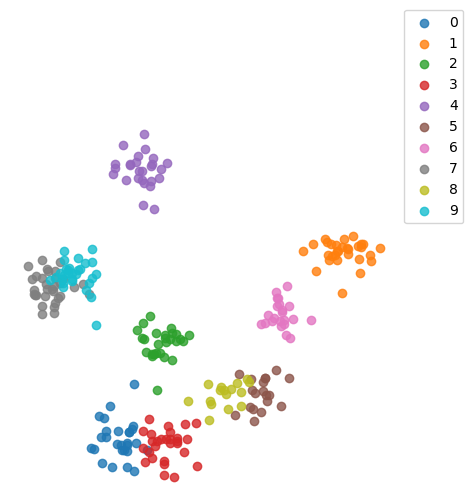

---

Train start
Training: 36 epoch. 100 iteration. Loss:0.001066827797330916
Training loss (ave.): 0.000636218461094107

Validation start:
Validation loss: 0.03124260022640228, Accuracy: 0.9899

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4346485526863053
within-class cov: 54674762.99799431, between-class cov: 78439069.60353947


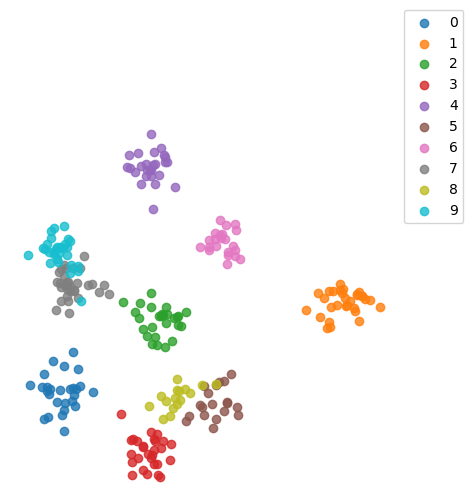

---

Train start
Training: 37 epoch. 100 iteration. Loss:0.0007991320453584194
Training loss (ave.): 0.0005503312082703602

Validation start:
Validation loss: 0.03122300822790712, Accuracy: 0.9894

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4410651807490567
within-class cov: 54824864.59757814, between-class cov: 79006203.41085139


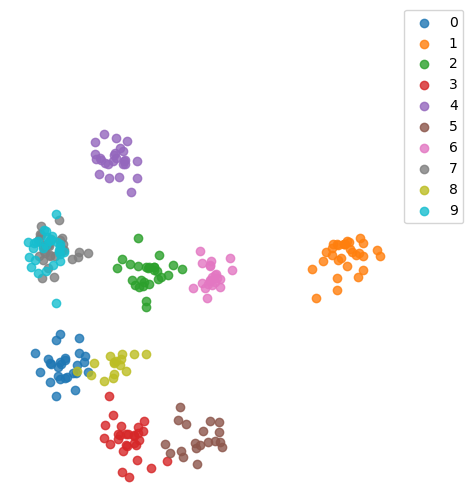

---

Train start
Training: 38 epoch. 100 iteration. Loss:0.0006945615750737488
Training loss (ave.): 0.000552664635247214

Validation start:
Validation loss: 0.03138452324289828, Accuracy: 0.9897

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4374337623456692
within-class cov: 54590392.88124326, between-class cov: 78470073.82721362


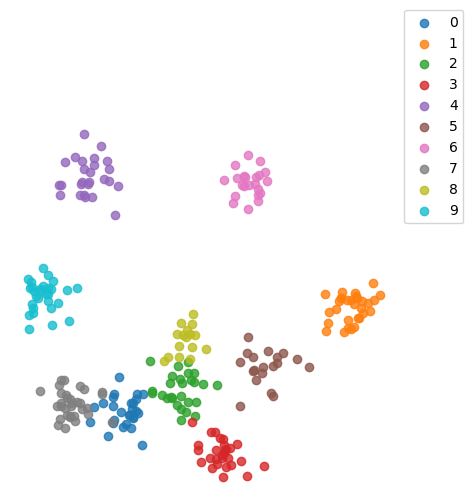

---

Train start
Training: 39 epoch. 100 iteration. Loss:0.0006193921435624361
Training loss (ave.): 0.000515382715000553

Validation start:
Validation loss: 0.03106326050385833, Accuracy: 0.99

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4418837880789495
within-class cov: 55046158.434023574, between-class cov: 79370163.4420441


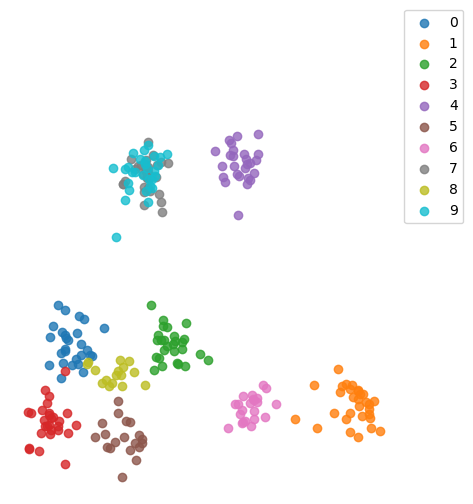

---

Train start
Training: 40 epoch. 100 iteration. Loss:0.0006484701298177242
Training loss (ave.): 0.0004097855335319454

Validation start:
Validation loss: 0.03184637007564888, Accuracy: 0.99

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4478278365711144
within-class cov: 55006972.427045114, between-class cov: 79640625.88537559


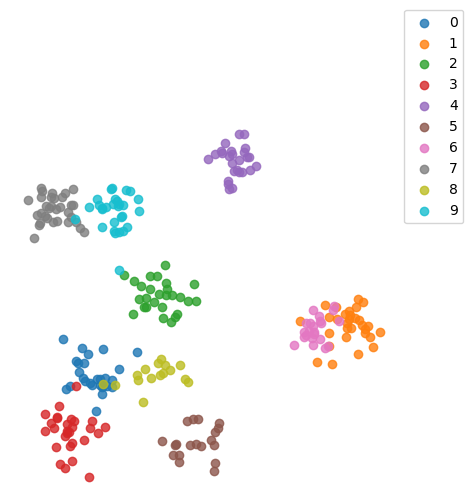

---

Train start
Training: 41 epoch. 100 iteration. Loss:0.0005857900250703096
Training loss (ave.): 0.00031482582451141576

Validation start:
Validation loss: 0.032116551859269385, Accuracy: 0.9888

Fisher discrinimant measure start:
Fisher desctiminant score: 1.451443894408108
within-class cov: 54980133.432982534, between-class cov: 79800578.98504546


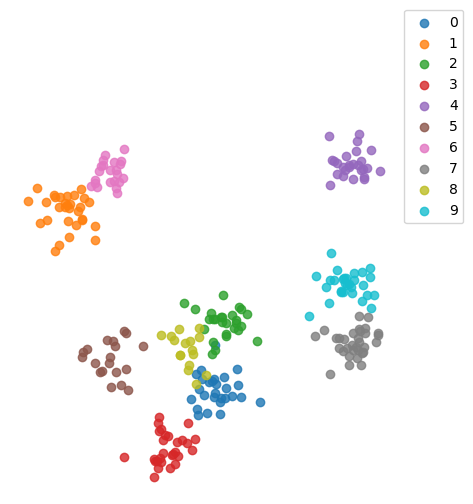

---

Train start
Training: 42 epoch. 100 iteration. Loss:0.00037430282100103796
Training loss (ave.): 0.0003081912375451561

Validation start:
Validation loss: 0.03116506167279149, Accuracy: 0.9902

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4582512492060218
within-class cov: 54925911.97379314, between-class cov: 80095779.74956371


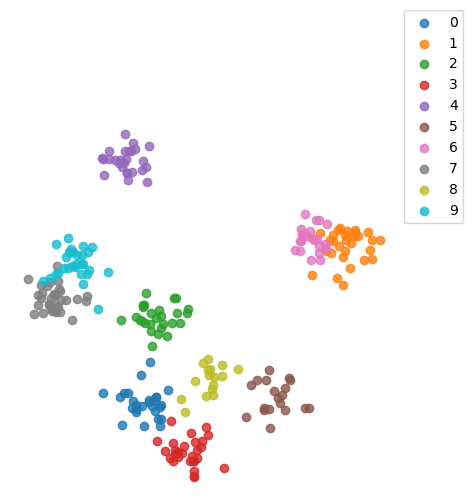

---

Train start
Training: 43 epoch. 100 iteration. Loss:0.0004277491243556142
Training loss (ave.): 0.0002429196206689317

Validation start:
Validation loss: 0.031190870082378388, Accuracy: 0.9908

Fisher discrinimant measure start:
Fisher desctiminant score: 1.469394191298856
within-class cov: 54778967.75644898, between-class cov: 80491897.02667347


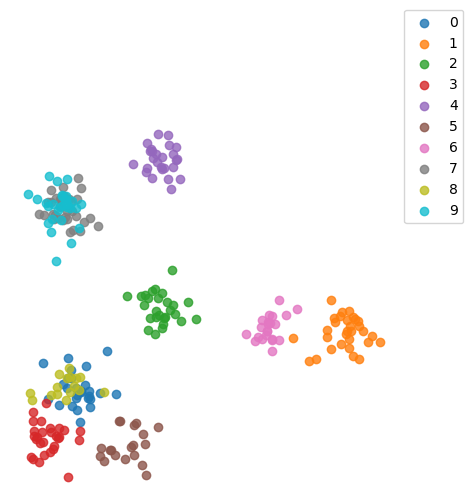

---

Train start
Training: 44 epoch. 100 iteration. Loss:0.000546559109352529
Training loss (ave.): 0.0003192942977778891

Validation start:
Validation loss: 0.031716471771418585, Accuracy: 0.99

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4640000904726276
within-class cov: 54892000.68368948, between-class cov: 80361893.96714474


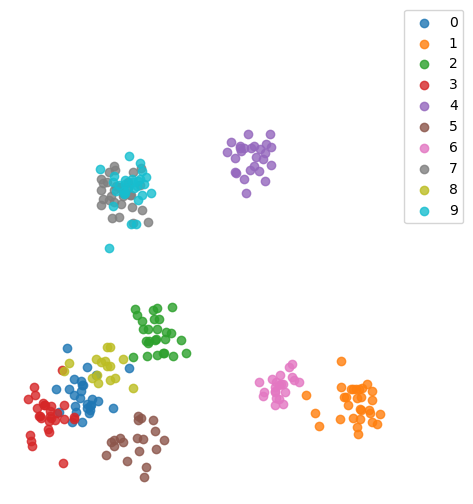

---

Train start
Training: 45 epoch. 100 iteration. Loss:0.0003701348614413291
Training loss (ave.): 0.0002305232234264506

Validation start:
Validation loss: 0.03138506743907928, Accuracy: 0.9902

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4654093748361636
within-class cov: 55076756.49546638, between-class cov: 80709995.3040252


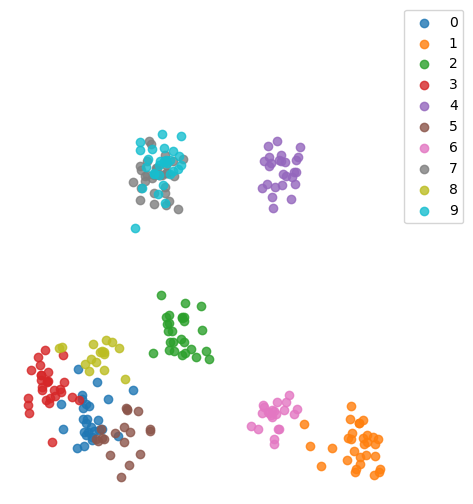

---

Train start
Training: 46 epoch. 100 iteration. Loss:0.00033839649404399097
Training loss (ave.): 0.00017390209243959808

Validation start:
Validation loss: 0.031172124391794204, Accuracy: 0.9902

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4740412451270877
within-class cov: 54841307.792525165, between-class cov: 80838349.62289144


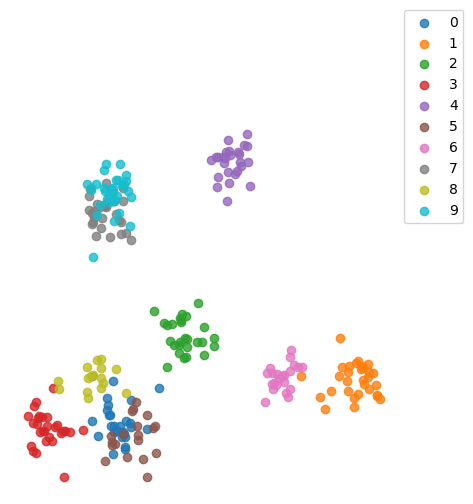

---

Train start
Training: 47 epoch. 100 iteration. Loss:0.00026200065622106194
Training loss (ave.): 0.0001709637491582358

Validation start:
Validation loss: 0.032075535049289464, Accuracy: 0.9902

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4772270313016729
within-class cov: 54862649.08568254, between-class cov: 81044588.23818812


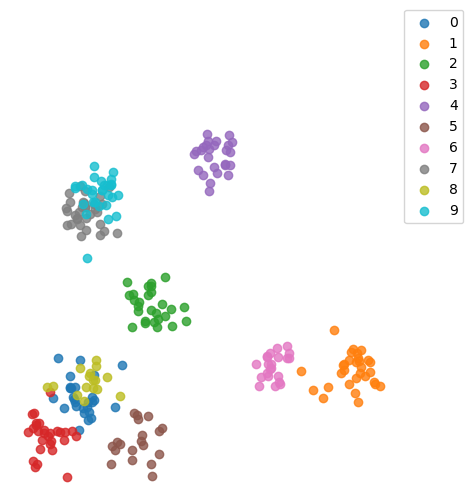

---

Train start
Training: 48 epoch. 100 iteration. Loss:0.0007660635747015476
Training loss (ave.): 0.0002472029572867967

Validation start:
Validation loss: 0.03171880052080378, Accuracy: 0.99

Fisher discrinimant measure start:
Fisher desctiminant score: 1.4787828258012423
within-class cov: 54791447.62217785, between-class cov: 81024651.74446511


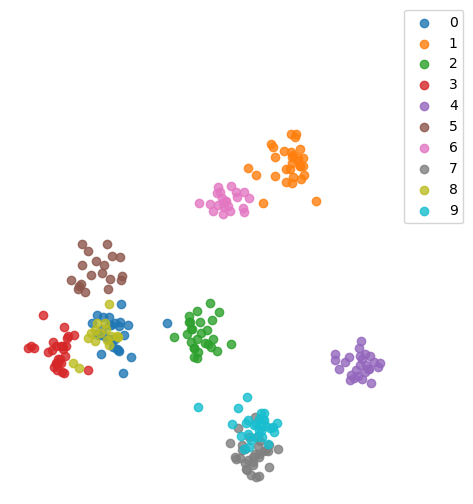

---

Train start
Training: 49 epoch. 100 iteration. Loss:0.00025260538677684963
Training loss (ave.): 0.00014064120632804376

Validation start:
Validation loss: 0.03154691842794418, Accuracy: 0.9905

Fisher discrinimant measure start:
Fisher desctiminant score: 1.481428324032009
within-class cov: 54815919.81067708, between-class cov: 81205856.2154042


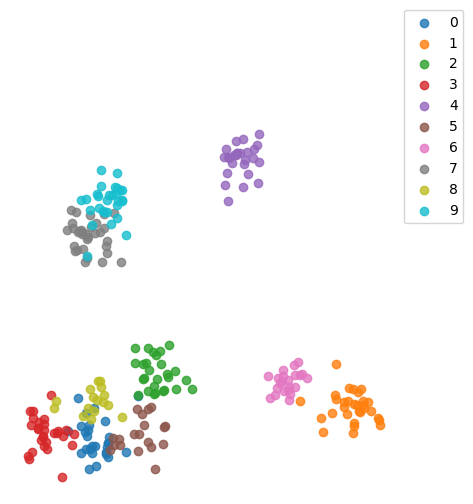

---

Train start
Training: 50 epoch. 100 iteration. Loss:0.00020764407236129045
Training loss (ave.): 0.00014124801295730186

Validation start:


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

for e in range(epoch):
    """ 学習部分 """
    loss = None
    train_loss = 0.0
    net.train() #学習モード
    print("\nTrain start")
    for i, (data, target) in enumerate(data_loader["train"]):
        data, target = data.to(device), target.to(device)
        
        #勾配の初期化
        optimizer.zero_grad()

        output = net(data)
        loss = f.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 99:
            print("Training: {} epoch. {} iteration. Loss:{}".format(e+1,i+1,loss.item()))
            break

    train_loss /= len(data_loader["train"])
    print("Training loss (ave.): {}".format(train_loss))
    history["train_loss"].append(train_loss)


    print("\nValidation start:")
    net.eval() #検証モード(Validation)
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for data,target in data_loader["validation"]:
            data,target = data.to(device),target.to(device)

            #順伝搬の計算
            output = net(data)
            loss = f.nll_loss(output,target).item()
            val_loss += f.nll_loss(output,target,reduction='sum').item()
            predict = output.argmax(dim=1,keepdim=True)
            accuracy += predict.eq(target.view_as(predict)).sum().item()

    val_loss /= len(data_loader["validation"].dataset)
    accuracy /= len(data_loader["validation"].dataset)

    print("Validation loss: {}, Accuracy: {}\n".format(val_loss,accuracy))
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(accuracy)
    
    # Fisher discriminant measure の計算：Zarka et al. 2020
    print("Fisher discrinimant measure start:")
    score, tr_b, tr_w = fisher_descriminant_score()
    history["fisher_score"].append(score)
    history["tr_w"].append(tr_w)
    history["tr_b"].append(tr_b)
    print(f"Fisher desctiminant score: {score}")
    print(f"within-class cov: {tr_w}, between-class cov: {tr_b}")
    
    # LDA projection
    net(X_display)

    x = net.last_feature.numpy()
            
    X_r = lda.fit(x, y_display).transform(x)
    
    cmap = plt.get_cmap("tab10")
    
    plt.figure(figsize=(5, 5), dpi=100)
    for i in range(10):
        plt.scatter(
            X_r[y_display == i, 0], X_r[y_display == i, 1], alpha=0.8, color=cmap(i), label=i
        )
    plt.legend(loc='center left', shadow=False, scatterpoints=1, bbox_to_anchor=(1,1))
    plt.show()
    
    print("---")
    

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["validation_loss"])
plt.show()
plt.plot(history["fisher_score"])
plt.show()
plt.plot(history["tr_w"])
plt.plot(history["tr_b"])
plt.legend(["tr_w", "tr_b"])

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()

In [ ]:
y == 0